In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 932.2 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2
import re
import zipfile
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from einops.layers.torch import Rearrange

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file_path = '/content/drive/MyDrive/deep_fake.zip'
destination_directory = '/content/deep_fake'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

# Print confirmation message
print("Unzipping complete!")

Unzipping complete!


In [5]:
import random
dataset_dir = '/content/deep_fake/Dataset/Train/Real'
folder = dataset_dir

random_img_path = os.path.join(folder, random.choice(os.listdir(folder)))
print("Random image size before preprocessing:", Image.open(random_img_path).size)

Random image size before preprocessing: (256, 256)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root="/content/deep_fake/Dataset/Train", transform=data_transform)


In [8]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numeric values (0 or 1)
encoded_labels = label_encoder.fit_transform(dataset.classes)

# Print the encoded labels
print(encoded_labels)

[0 1]


In [9]:
from torch.utils.data import Subset

# Separate samples by class
real_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Real"]
fake_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Fake"]

# Randomly sample 20,000 samples from each class
real_samples = np.random.choice(real_samples, 25000, replace=False)
fake_samples = np.random.choice(fake_samples, 25000, replace=False)

# Combine the sampled indices
filtered_indices = np.concatenate([real_samples, fake_samples])
filtered_samples = [dataset.samples[idx] for idx in filtered_indices]

# Create a Subset dataset using the filtered samples
filtered_dataset = Subset(dataset, filtered_indices)

In [10]:
dataset = filtered_dataset
# Define sizes for train, validation, and test sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train, validation, and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
vali_size = int(0.11112*len(train_set))
train_size = len(train_set) - vali_size
train_set, vali_set = torch.utils.data.random_split(train_set, [train_size, vali_size])

# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32,shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=32,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32,shuffle=True)

In [11]:
print(len(train_set))
print(len(vali_set))
print(len(test_set))

40000
5000
5000


In [12]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            #Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Conv2d(256, 256*6**2,kernel_size=3,stride=3)
        )
        self.flatten = nn.Flatten(start_dim=1,end_dim=2)

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        x = x.permute((0, 2, 3, 1))
        x = self.flatten(x)
        return x

In [13]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.n_heads = 2
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=12,
                                               dropout=0.2)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [14]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [15]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(0.2)
        )

In [16]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [17]:
import torch
import torch.nn as nn
from einops import repeat
from torchvision.models import resnet18

class Vision_transformer(nn.Module):
    def __init__(self, patch_size=14, emb_dim=9216, n_layers=2, dropout=0.2, num_classes=2):
        super(Vision_transformer, self).__init__()

        # Attributes
        self.height = 224
        self.width = 224
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Load pre-trained ResNet without final layer
        resnet =resnet18(pretrained=True)
        self.new_reset = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze parameters of ResNet backbone
        for param in self.new_reset.parameters():
            param.requires_grad = False

        # Patching
        self.patch_embedding = PatchEmbedding()

        # Learnable params
        self.pos_embedding = nn.Parameter(torch.randn(1, 5, emb_dim),requires_grad=True)
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim),requires_grad=True)

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim))))
            self.layers.append(transformer_block)

        # Classification head with modified final layer
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)  # Modify output dimension to num_classes
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, img):
        with torch.no_grad():
            features = self.new_reset(img)
        # Get patch embedding vectors
        x = self.patch_embedding(features)

        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = self.cls_token.expand(b, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)
        # Add positional embeddings
        x += self.pos_embedding
        x = self.dropout(x)

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)
        # Classification token
        x = x[:, 0]
        x = self.head(x)

        # Output based on classification token
        return x

# Create an instance of Vision_transformer
model = Vision_transformer(num_classes=1)  # Example: 1 output class for binary classification

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 175MB/s]


In [18]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

cuda


In [19]:
def train_and_validate(model, train_loader, vali_loader, device, num_epochs):
    train_losses, train_accuracies = [], []
    validation_losses, validation_accuracies = [], []
    train_predictions = []
    vali_predictions = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_predicted_true = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predictions = torch.sigmoid(outputs)
            predictions_classified = torch.where(predictions > 0.5, torch.tensor(1.0), torch.tensor(0.0))
            for i in range(len(predictions_classified)):
              if predictions_classified[i] == labels[i]:
                train_predicted_true += 1
            # Convert sigmoid outputs to binary predictions
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_predicted_true*100 / len(train_set))

        # Validation
        model.eval()
        vali_loss = 0
        vali_predicted_true = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in vali_loader:
                inputs, labels = inputs.to(device),labels.float().to(device)
                outputs = model(inputs)
                vali_loss += criterion(outputs.squeeze(), labels).item()
                vali_predictions = torch.sigmoid(outputs)
                vali_predictions_classified = torch.where(vali_predictions > 0.5, torch.tensor(1.0), torch.tensor(0.0))
                for i in range(len(vali_predictions_classified)):
                  if vali_predictions_classified[i] == labels[i]:
                    vali_predicted_true += 1

                total_val += labels.size(0)

        vali_loss_epoch = vali_loss / len(vali_loader)
        vali_acc_epoch = vali_predicted_true*100 / len(vali_set)
        validation_losses.append(vali_loss_epoch)
        validation_accuracies.append(vali_acc_epoch)

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Validation Loss: {validation_losses[-1]:.4f}, Accuracy: {validation_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


In [20]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
    model=model,
    train_loader=train_loader,
    vali_loader=vali_loader,
    device=device,
    num_epochs=10)

Epoch 1/10
Training Loss: 191.3617, Accuracy: 49.4225
Validation Loss: 53.1428, Accuracy: 51.8200
Epoch 2/10
Training Loss: 56.9945, Accuracy: 49.6675
Validation Loss: 53.1428, Accuracy: 51.8200
Epoch 3/10
Training Loss: 56.6387, Accuracy: 50.0125
Validation Loss: 53.1339, Accuracy: 51.8200
Epoch 4/10
Training Loss: 56.5016, Accuracy: 49.7400
Validation Loss: 53.1428, Accuracy: 51.8200
Epoch 5/10
Training Loss: 56.4712, Accuracy: 50.1950
Validation Loss: 53.1516, Accuracy: 51.8200
Epoch 6/10
Training Loss: 56.3866, Accuracy: 50.1225
Validation Loss: 53.1516, Accuracy: 48.1800
Epoch 7/10
Training Loss: 56.3154, Accuracy: 50.1000
Validation Loss: 53.1251, Accuracy: 51.8200
Epoch 8/10
Training Loss: 56.3106, Accuracy: 49.7700
Validation Loss: 53.1251, Accuracy: 51.8200
Epoch 9/10
Training Loss: 56.2429, Accuracy: 49.7275
Validation Loss: 53.1339, Accuracy: 48.1800
Epoch 10/10
Training Loss: 56.2348, Accuracy: 50.2300
Validation Loss: 53.1516, Accuracy: 51.8200


In [21]:
def test(model):
  correct_test = 0
  test_loss = 0
  total_test=0
  test_predictions = []
  labels_test_total = []
  test_predicted_true = 0
  with torch.no_grad():
    for inputs, labels_test in test_loader:
        inputs,labels_test = inputs.to(device), labels_test.float().to(device)
        test_output = model(inputs)
        loss = criterion(test_output.squeeze(), labels_test)
        test_loss += loss.item()
        predicted_test_classes = torch.sigmoid(test_output)
        predicted_test_classes_modified = predicted_test_classes.clone()
        predicted_test_classes_modified[test_output > 0.5] = 1.0
        predicted_test_classes_modified[test_output <= 0.5] = 0.0
        for i in range(len(predicted_test_classes_modified)):
          if predicted_test_classes_modified[i] == labels_test[i]:
            test_predicted_true += 1
        total_test += labels_test.size(0)
        test_predictions.extend(predicted_test_classes_modified)
        labels_test_total.extend(labels_test)

  test_loss = test_loss / len(test_loader)
  test_accuracy = 100 * test_predicted_true / len(test_set)

  print(f"Test Accuracy: {test_accuracy:.2f}%")
  print(f"Test Loss: {test_loss:.4f}")

  return labels_test_total, test_predictions, predicted_test_classes, test_loss, test_accuracy


In [22]:
test_labels, test_predictions, predicted_test_classes, test_loss, test_accuracy = test(model)

Test Accuracy: 50.60%
Test Loss: 54.5070


In [23]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns

def metrics(labels_test_total, predicted_test_classes, test_probabilities, test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies):

    # Move tensors to CPU and detach from the computation graph
    labels_test_cpu = [labels.cpu() for labels in labels_test_total]
    predicted_test_classes_cpu = [predictions.cpu() for predictions in predicted_test_classes]
    test_probabilities_cpu = test_probabilities.cpu().detach().numpy()
    test_loss_cpu = test_loss

    accuracy = accuracy_score(labels_test_cpu, predicted_test_classes_cpu)
    precision = precision_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    recall = recall_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    f1Score = f1_score(labels_test_cpu, predicted_test_classes_cpu, average='micro')
    classify_report = classification_report(labels_test_cpu, predicted_test_classes_cpu)

    # Print classification metrics
    print("Accuracy:", accuracy)
    print("precision_score: ", precision)
    print("recall_score: ", recall)
    print("f1_score: ", f1Score)
    print("Classification Report:")
    print(classify_report)

    # Plot loss and accuracy curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(validation_losses, label='Validation Loss')
    ax1.axhline(y=test_loss_cpu, color='r', linestyle='--', label='Test Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(validation_accuracies, label='Validation Accuracy')
    ax2.axhline(y=accuracy, color='r', linestyle='--', label='Test Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test_cpu, predicted_test_classes_cpu)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.506
precision_score:  0.506
recall_score:  0.506
f1_score:  0.506
Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      1.00      0.67      2530
         1.0       0.00      0.00      0.00      2470

    accuracy                           0.51      5000
   macro avg       0.25      0.50      0.34      5000
weighted avg       0.26      0.51      0.34      5000



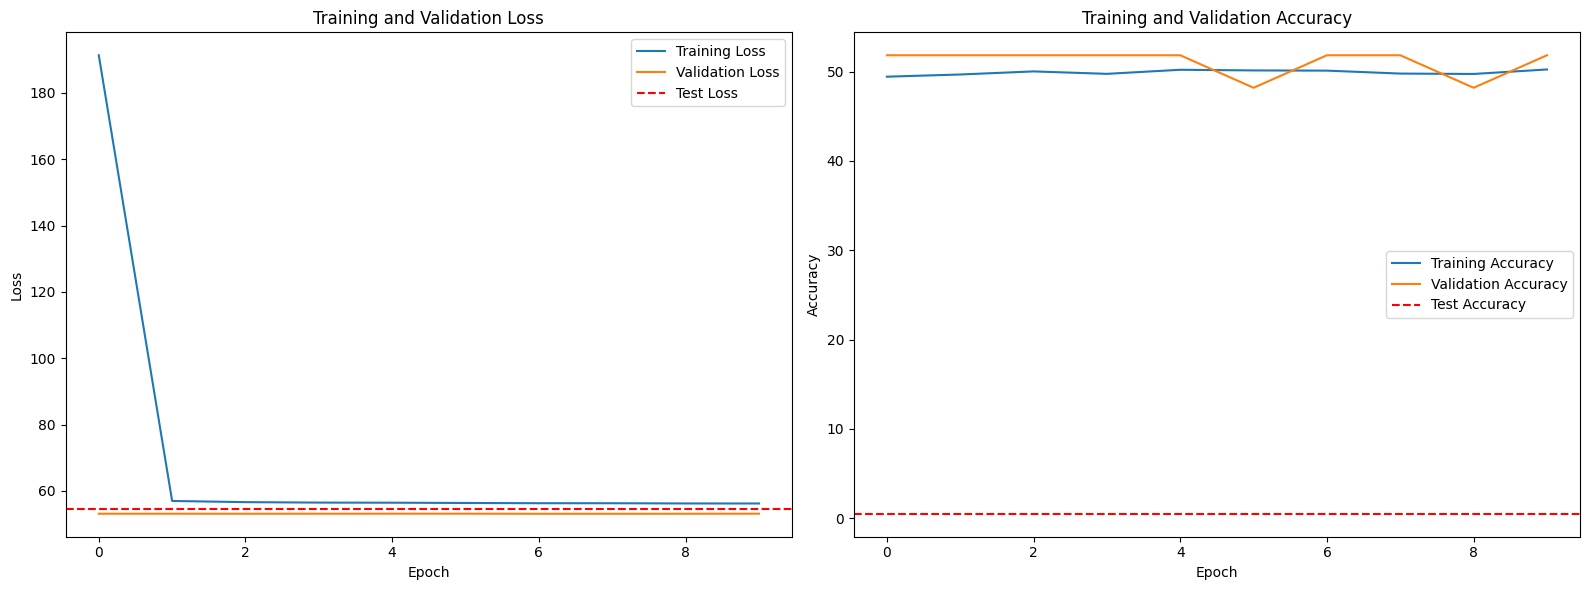

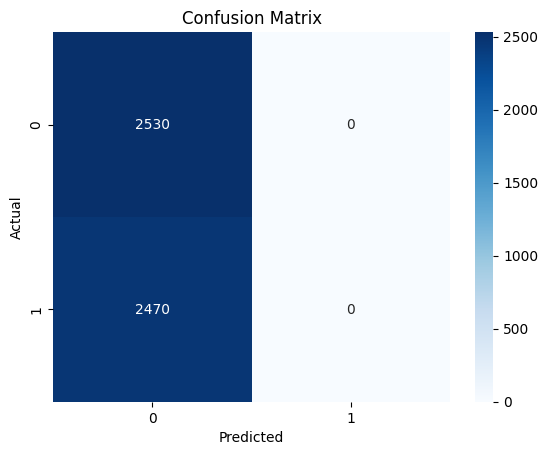

In [24]:
metrics(test_labels, test_predictions, predicted_test_classes.cpu(), test_loss, train_losses, validation_losses, train_accuracies, validation_accuracies)